In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Add random horizontal flips and crops to the dataset
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4),
     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
     transforms.RandomRotation(15),  # Randomly rotate the image by up to 15 degrees
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform )


# Introduce 20% label noise
def add_label_noise(dataset, noise_level=0.2):
    num_samples = len(dataset)
    num_noisy_labels = int(noise_level * num_samples)

    indices = np.random.choice(num_samples, num_noisy_labels, replace=False)
    noisy_labels = np.random.randint(0, 10, num_noisy_labels)

    for idx, noisy_label in zip(indices, noisy_labels):
        dataset.targets[idx] = noisy_label

add_label_noise(trainset,noise_level=0.5)



trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

# Create two identical ResNet models with different initializations
net1 = torchvision.models.resnet18(num_classes=10)
net2 = torchvision.models.resnet18(num_classes=10)

# def init_weights(m):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#         torch.nn.init(m.weight)

# net1.apply(init_weights)
# net2.apply(init_weights)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net1 = net1.to(device)
net2 = net2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(net1.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
optimizer2 = optim.SGD(net2.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)

def train(net, optimizer, epoch, trainloader):
    net.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
    return avg_loss


def compute_dispersion(net1, net2, loader):
    net1.eval()
    net2.eval()
    classifcation_discrepancy = 0.0
    jsd_dipcepancy = 0.0
    l2_discrepancy = 0.0
    num_samples = len(loader.dataset)
    with torch.no_grad():
        for batch_idx, (inputs, _) in enumerate(loader):
            inputs = inputs.to(device)
            outputs1 = net1(inputs)
            outputs2 = net2(inputs)    
            classifcation_discrepancy += compute_classification_discrepancy(outputs1, outputs2)
            jsd_dipcepancy += compute_jsd_discrepancy(outputs1, outputs2)
            l2_discrepancy += compute_l2_discrepancy(outputs1, outputs2)
    classifcation_discrepancy /= num_samples
    jsd_dipcepancy /= num_samples
    l2_discrepancy /= num_samples
    return classifcation_discrepancy, jsd_dipcepancy, l2_discrepancy

# To calculate the discrepancy between the two networks' outputs
def compute_classification_discrepancy(outputs1, outputs2):

    y1 = torch.argmax(outputs1,dim=1)
    y2 = torch.argmax(outputs2,dim=1)
    discrepancy = torch.sum(y1!=y2)

    return discrepancy
 


# # To calculate the weight discrepancy between the two networks
# def compute_weight_discrepancy(net1, net2):
#     total_discrepancy = 0.0
#     total_params = 0
#     for (param1, param2) in zip(net1.parameters(), net2.parameters()):
#         total_discrepancy += torch.sum((param1 - param2) ** 2).item()
#         total_params += param1.numel()
#     return (total_discrepancy / total_params) ** 0.5

# def compute_average_layerwise_weight_discrepancy(net1, net2):
#     total_discrepancy = 0.0
#     layer_count = 0

#     for (param1, param2) in zip(net1.parameters(), net2.parameters()):
#         # Compute the sum of weights for each layer
#         sum_weights1 = torch.sum(param1).item()
#         sum_weights2 = torch.sum(param2).item()

#         # Calculate the absolute difference in sums of weights for the layer
#         layer_discrepancy = abs(sum_weights1 - sum_weights2)

#         total_discrepancy += layer_discrepancy
#         layer_count += 1

#     # Compute the average discrepancy across all layers
#     average_discrepancy = total_discrepancy / layer_count
#     return average_discrepancy


def compute_jsd_discrepancy(output1, output2):

    epsilon = 1e-10  # Small constant to avoid log(0)

    outputs1 = F.softmax(output1, dim=1) + epsilon
    outputs2 = F.softmax(output2, dim=1) + epsilon

    # Re-normalize the distributions after adding epsilon
    outputs1 = outputs1 / torch.sum(outputs1, dim=1, keepdim=True)
    outputs2 = outputs2 / torch.sum(outputs2, dim=1, keepdim=True)

    # Calculate the Jensen-Shannon Divergence
    m = 0.5 * (outputs1 + outputs2)
    jsd = 0.5 * (F.kl_div(outputs1.log(), m, reduction='sum') + F.kl_div(outputs2.log(), m, reduction='sum'))
    return jsd.item()






# To calculate the discrepancy between the two networks' outputs
def compute_l2_discrepancy(outputs1, outputs2):

    return torch.sum(torch.norm(outputs1-outputs2,p=2,dim=1))



Files already downloaded and verified


In [34]:

# Train both networks and compute discrepancies
classification_discrepancies = []
weight_discrepancies = []
outputs_discrepancies = []

jsd_discrepancies = []

losses1 = []
losses2 = []

for epoch in range(30):  # Letimport torch.nn.functional as F's train for 10 epochs
    print(f"--- Epoch {epoch} ---")
    # discrepancy = compute_classification_discrepancy(net1, net2, trainloader) # ORIGINAL FROM PAPER
    # discrepancy = discrepancy.detach().cpu().numpy()
    # discrepancies.append(discrepancy)

    classification_discrepancy , jsd_discrepancy , outputs_discrepancy = compute_dispersion(net1, net2, trainloader)  # ORIGINAL FROM PAPER



    classification_discrepancies.append(classification_discrepancy)
    # weight_discrepancies.append(weight_discrepancy)
    jsd_discrepancies.append(jsd_discrepancy)
    outputs_discrepancies.append(outputs_discrepancy)

    print(f'Epoch {epoch}, Classification Discrepancy: {classification_discrepancy:.4f}, 'f'JSD: {jsd_discrepancy:.4f},' f'outputs_discrepancy:{outputs_discrepancy}' )



    #print(f'Epoch {epoch+1}, Discrepancy: {discrepancy:.4f}')

    loss1 = train(net1, optimizer1, epoch, trainloader)
    loss2 = train(net2, optimizer2, epoch, trainloader)

    losses1.append(loss1)
    losses2.append(loss2)





--- Epoch 0 ---
Epoch 0, Classification Discrepancy: 1.0000, JSD: 0.0598,outputs_discrepancy:2.419757604598999
Epoch 1, Loss: 2.3075
Epoch 1, Loss: 2.3146
--- Epoch 1 ---
Epoch 1, Classification Discrepancy: 0.5429, JSD: 0.0513,outputs_discrepancy:1.7412090301513672
Epoch 2, Loss: 2.2120
Epoch 2, Loss: 2.2313
--- Epoch 2 ---
Epoch 2, Classification Discrepancy: 0.5487, JSD: 0.0424,outputs_discrepancy:1.5625559091567993
Epoch 3, Loss: 2.1803
Epoch 3, Loss: 2.1816
--- Epoch 3 ---
Epoch 3, Classification Discrepancy: 0.4875, JSD: 0.0394,outputs_discrepancy:1.5248054265975952
Epoch 4, Loss: 2.1486
Epoch 4, Loss: 2.1547
--- Epoch 4 ---
Epoch 4, Classification Discrepancy: 0.4433, JSD: 0.0452,outputs_discrepancy:1.4939260482788086
Epoch 5, Loss: 2.1299
Epoch 5, Loss: 2.1312
--- Epoch 5 ---
Epoch 5, Classification Discrepancy: 0.4689, JSD: 0.0702,outputs_discrepancy:1.7564138174057007
Epoch 6, Loss: 2.1095
Epoch 6, Loss: 2.1112
--- Epoch 6 ---
Epoch 6, Classification Discrepancy: 0.4326, JSD:

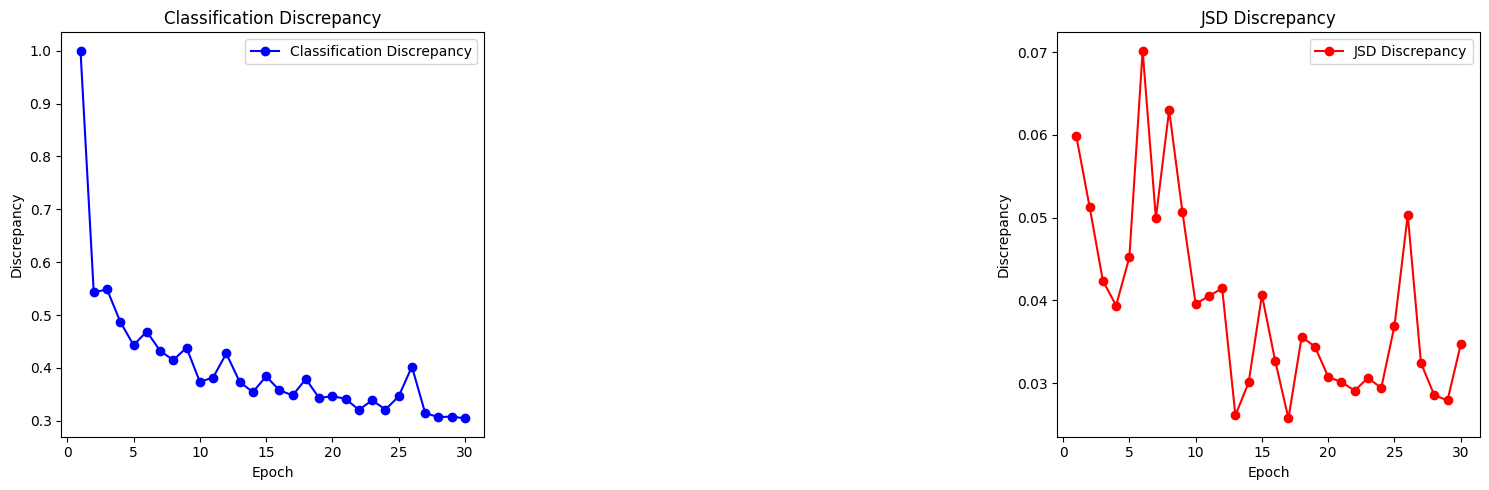

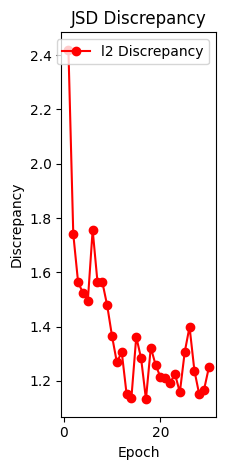

: 

In [35]:
import matplotlib.pyplot as plt

# Assuming the following lists are filled with data from the training loop
epochs = list(range(1, 31))  # Since you are running for 30 epochs

# Convert tensors to CPU and then to NumPy arrays
classification_discrepancies_cpu = [discrepancy.cpu().numpy() for discrepancy in classification_discrepancies]
jsd_discrepancies_cpu = [discrepancy for discrepancy in jsd_discrepancies]
outputs_discrepancies_cpu = [discrepancy.cpu().numpy() for discrepancy in outputs_discrepancies]
#print(len(weight_discrepancies_cpu))
# Verify lengths
assert len(classification_discrepancies_cpu) == 30, "Mismatch in length for classification_discrepancies_cpu"
#assert len(weight_discrepancies_cpu) == 30, "Mismatch in length for weight_discrepancies_cpu"
assert len(jsd_discrepancies_cpu) == 30, "Mismatch in length for jsd_discrepancies_cpu"

# Plotting
plt.figure(figsize=(15, 5))

# Plot Classification Discrepancy
plt.subplot(1, 3, 1)
plt.plot(epochs, classification_discrepancies_cpu, label='Classification Discrepancy', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Discrepancy')
plt.title('Classification Discrepancy')
plt.legend()

# # Plot Average Layer-wise Weight Discrepancy
# plt.subplot(1, 3, 2)
# plt.plot(epochs, average_discrepancy, label='Average Layer-wise Weight Discrepancy', color='green', marker='o')
# plt.xlabel('Epoch')
# plt.ylabel('Discrepancy')
# plt.title('Average Layer-wise Weight Discrepancy')
# plt.legend()

# Plot Jensen-Shannon Divergence (JSD) Discrepancy
plt.subplot(1, 3, 3)
plt.plot(epochs, jsd_discrepancies_cpu, label='JSD Discrepancy', color='red', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Discrepancy')
plt.title('JSD Discrepancy')
plt.legend()

plt.tight_layout()
plt.show()


plt.subplot(1, 3, 3)
plt.plot(epochs, outputs_discrepancies_cpu, label='l2 Discrepancy', color='red', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Discrepancy')
plt.title('JSD Discrepancy')
plt.legend()

plt.tight_layout()
plt.show()